In [1]:
#Installing the imbalanced learn module for access to a variety of over-sampling methods

#!pip install imbalanced-learn
#!pip install numpy==1.21
#!pip install lxml

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Data/clean_gss.csv')
df.head()

,Unnamed: 0,LONELY2,SATJOB,MOREDAYS,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,AGE,MARITAL,EDUC,is_si,marital_cat,MOREWEEKS,Age Group
0,3,2.0,1.0,2.0,1.0,1.0,1.0,4.0,3.0,63.0,1.0,4,0,1,1,4
1,6,3.0,1.0,1.0,1.0,3.0,2.0,3.0,2.0,59.0,3.0,3,1,0,1,3
2,7,1.0,1.0,24.0,1.0,2.0,3.0,4.0,5.0,43.0,5.0,2,0,0,4,2
3,9,3.0,2.0,3.0,1.0,2.0,3.0,4.0,1.0,55.0,1.0,2,1,1,1,3
4,11,3.0,2.0,6.0,1.0,3.0,3.0,2.0,1.0,34.0,4.0,3,1,0,1,2


In [3]:
# Getting rid of redundant columns from initial dataframe

gss= df[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','marital_cat', 'EDUC', 'is_si', 'MOREWEEKS', 'Age Group']]
gss.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,marital_cat,EDUC,is_si,MOREWEEKS,Age Group
0,1.0,1.0,1.0,1.0,4.0,3.0,1,4,0,1,4
1,1.0,1.0,3.0,2.0,3.0,2.0,0,3,1,1,3
2,1.0,1.0,2.0,3.0,4.0,5.0,0,2,0,4,2
3,2.0,1.0,2.0,3.0,4.0,1.0,1,2,1,1,3
4,2.0,1.0,3.0,3.0,2.0,1.0,0,3,1,1,2


<AxesSubplot:>

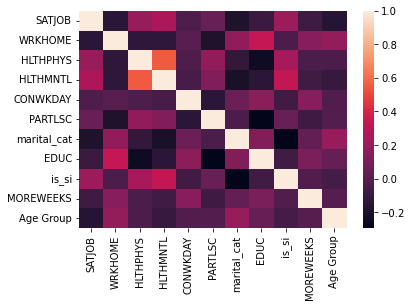

In [4]:
# Checking for multicollinearity- looks good

corr = gss.corr()
sns.heatmap(corr)

In [5]:
# Marital status is the only nominal categorical variable in this dataframe. Using get_dummies to one-hot encode and
# dropping first level of marital status: a zero for marital_2, marital_3, marital_4, and marital_5 implies row belongs
# to marital_1. The rest of the variables are ordinal and attempting to run logit with variables as-is.

gss= pd.get_dummies(gss, columns= ['marital_cat'], prefix= 'Marital', drop_first= True)
gss.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,EDUC,is_si,MOREWEEKS,Age Group,Marital_1
0,1.0,1.0,1.0,1.0,4.0,3.0,4,0,1,4,1
1,1.0,1.0,3.0,2.0,3.0,2.0,3,1,1,3,0
2,1.0,1.0,2.0,3.0,4.0,5.0,2,0,4,2,0
3,2.0,1.0,2.0,3.0,4.0,1.0,2,1,1,3,1
4,2.0,1.0,3.0,3.0,2.0,1.0,3,1,1,2,0


In [6]:
# Starting to split data to prepare for modeling

X= gss[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','EDUC', 'MOREWEEKS', 'Age Group', 'Marital_1' ]]
y= gss['is_si']

In [7]:
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os= SMOTEN(random_state= 42)
os_X, os_y= os.fit_resample(X_train, y_train)

In [8]:
# Verifying we now have 50/50 isolated to non-isolated for training data

os_y.value_counts()

1    364
0    364
Name: is_si, dtype: int64

In [9]:
# SATJOB, HLTHPHYS, PARTLSC, MARITAL_2, MARITAL_5 all have p-value above 0.05 lacking statistical significance

import statsmodels.api as sm

sm_logit = sm.Logit(os_y, os_X)
result = sm_logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.556043
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  728
Model:                          Logit   Df Residuals:                      718
Method:                           MLE   Df Model:                            9
Date:                Wed, 05 Apr 2023   Pseudo R-squ.:                  0.1978
Time:                        09:47:06   Log-Likelihood:                -404.80
converged:                       True   LL-Null:                       -504.61
Covariance Type:            nonrobust   LLR p-value:                 3.974e-38
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SATJOB         0.1849      0.114      1.624      0.104      -0.038       0.408
WRKHOME       -0.1737      0.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

sk_logit = LogisticRegression()
sk_logit.fit(os_X, os_y)
y_pred = sk_logit.predict(X_test)
print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))

Accuracy on test set:0.72


In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       156
           1       0.46      0.71      0.56        51

    accuracy                           0.72       207
   macro avg       0.67      0.72      0.68       207
weighted avg       0.78      0.72      0.74       207



In [12]:
for age_group in gss['Age Group'].unique():
    age = gss.loc[gss['Age Group']== age_group]
    
    # Starting to split data to prepare for modeling
    
    #'Marital_2.0','Marital_3.0', 'Marital_4.0', 'Marital_5.0'
    X= age[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','EDUC', 'MOREWEEKS','Marital_1']]
    y= age['is_si']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

    # Resampling only the training data
    os= SMOTEN(random_state= 42)
    os_X, os_y= os.fit_resample(X_train, y_train)

    sm_logit = sm.Logit(os_y, os_X)
    result = sm_logit.fit()
    print("Age Group:{:.2f}".format(age_group))
    print(result.summary())

    sk_logit = LogisticRegression()
    sk_logit.fit(os_X, os_y)
    y_pred = sk_logit.predict(X_test)
    print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))

#Saving summary data to a dataframe for plots
    if age_group==1.0:
        summary_df1 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==2.0:
        summary_df2 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==3.0:
        summary_df3 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==4.0:
        summary_df4 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]


    

Optimization terminated successfully.
         Current function value: 0.366265
         Iterations 7
Age Group:4.00
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  104
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            8
Date:                Wed, 05 Apr 2023   Pseudo R-squ.:                  0.4716
Time:                        09:47:17   Log-Likelihood:                -38.092
converged:                       True   LL-Null:                       -72.087
Covariance Type:            nonrobust   LLR p-value:                 1.233e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SATJOB        -0.6111      0.548     -1.114      0.265      -1.686       0.464
WRKHOME       

In [13]:
#Create a new list to hold data that will be used for plotting
summary_plot = []

#Add a new column in each summary dataframe that indicates the Age group of the dataframe
summary_df1['Age Group'] = 1
summary_df2['Age Group'] = 2
summary_df3['Age Group'] = 3
summary_df4['Age Group'] = 4

for table in [summary_df1,summary_df2,summary_df3,summary_df4]:
    #Track the index
    index= 0
    for row in table['P>|z|']:
        
        if row <= .05:
            summary_plot.append(table.iloc[index])
        index+=1
       

In [14]:
plot_data = pd.DataFrame(summary_plot)
plot_data['Variable']= plot_data.index

In [15]:
plot_data

,coef,std err,z,P>|z|,[0.025,0.975],Age Group,Variable
HLTHPHYS,0.6101,0.237,2.569,0.010,0.145,1.076,1.0,HLTHPHYS
PARTLSC,-0.3966,0.132,-3.016,0.003,-0.654,-0.139,1.0,PARTLSC
MOREWEEKS,-0.5286,0.242,-2.188,0.029,-1.002,-0.055,1.0,MOREWEEKS
Marital_1,-3.4381,1.162,-2.960,0.003,-5.715,-1.162,1.0,Marital_1
WRKHOME,-0.2769,0.107,-2.584,0.010,-0.487,-0.067,2.0,WRKHOME
HLTHMNTL,0.4365,0.197,2.221,0.026,0.051,0.822,2.0,HLTHMNTL
CONWKDAY,-0.2888,0.118,-2.443,0.015,-0.521,-0.057,2.0,CONWKDAY
Marital_1,-1.7287,0.322,-5.364,0.000,-2.360,-1.097,2.0,Marital_1
SATJOB,-1.2831,0.337,-3.808,0.000,-1.944,-0.623,3.0,SATJOB
WRKHOME,-0.4161,0.176,-2.359,0.018,-0.762,-0.070,3.0,WRKHOME


In [16]:
clean_plot_data = pd.DataFrame(pd.crosstab(plot_data['Age Group'],plot_data['Variable'],values=plot_data['coef'],aggfunc=sum))
clean_plot_data

Variable,CONWKDAY,HLTHMNTL,HLTHPHYS,MOREWEEKS,Marital_1,PARTLSC,SATJOB,WRKHOME
Age Group,,,,,,,,
1.0,NaN,NaN,0.6101,-0.5286,-3.4381,-0.3966,NaN,NaN
2.0,-0.2888,0.4365,NaN,NaN,-1.7287,NaN,NaN,-0.2769
3.0,-0.2873,1.5873,NaN,NaN,-1.5153,0.2805,-1.2831,-0.4161
4.0,-0.7550,NaN,NaN,NaN,-2.9782,NaN,NaN,NaN


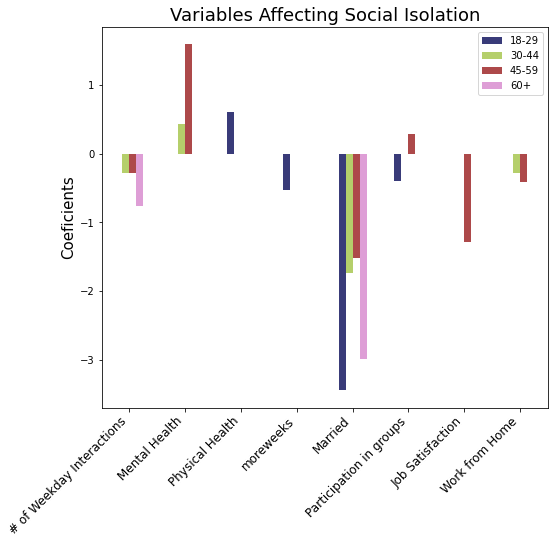

In [17]:
#plt.figure(figsize=(10,10))
ax = clean_plot_data.transpose().plot.bar(figsize=(8,7),rot=0,cmap='tab20b')

plt.title('Variables Affecting Social Isolation', fontsize=18)
plt.ylabel('Coeficients',fontsize=15)
plt.xlabel('',fontsize=15)
ax.tick_params(axis='y',labelsize=10)
ax.tick_params(axis='x', labelsize=12,rotation=45)
ax.set_xticklabels(['# of Weekday Interactions', 'Mental Health', 'Physical Health','moreweeks','Married','Participation in groups','Job Satisfaction','Work from Home'])
plt.setp(ax.xaxis.get_majorticklabels(), ha="right" )
ax.legend(labels=['18-29', '30-44','45-59','60+'])

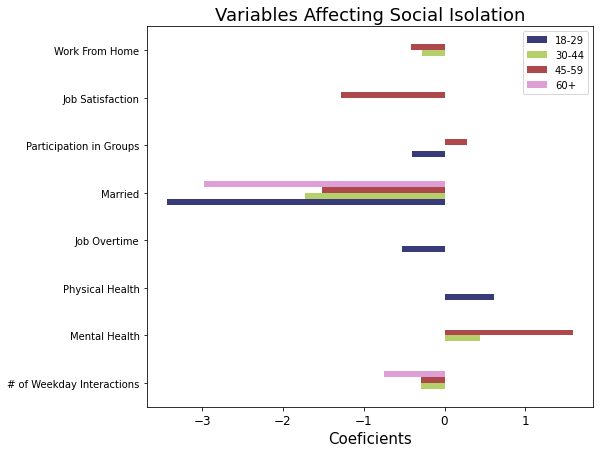

In [19]:
#plt.figure(figsize=(10,10))
ax = clean_plot_data.transpose().plot.barh(figsize=(8,7),rot=0,cmap='tab20b')

plt.title('Variables Affecting Social Isolation', fontsize=18)
plt.xlabel('Coeficients',fontsize=15)
plt.ylabel('',fontsize=15)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.set_yticklabels(['# of Weekday Interactions', 'Mental Health', 'Physical Health','Job Overtime','Married','Participation in Groups','Job Satisfaction','Work From Home'])
plt.setp(ax.yaxis.get_majorticklabels(), ha="right" )
ax.legend(labels=['18-29', '30-44','45-59','60+'])